## Example 1. Simple graphical model using tensorflow auto diff

Following this [tutorial](https://www.youtube.com/watch?v=dxwVMeK988Y&ab_channel=MachineLearning%26SimulationMachineLearning%26Simulation)

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

We have a dataset we know is normally distributed with a known variance but an unknown mean.

![alt](graphical_model.png)

Generate the data

In [2]:
mu_true = 4.0
sigma_true = 2.0

X = tfp.distributions.Normal(loc=mu_true, scale=sigma_true)

N = 1000
dataset = X.sample(N)

<AxesSubplot:ylabel='Density'>

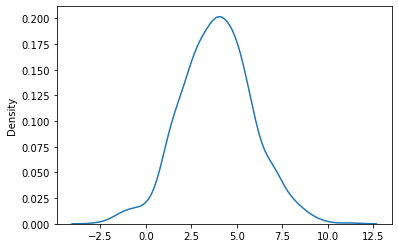

In [3]:
sns.kdeplot(dataset)

Our prior knowledge of where we expect $\mu$ to lie. We say $\mu$ is normally distributed with mean and std $\mu_0$ and $\sigma_0$, 

In [4]:
mu_0 = 2.8 # a guess, depends on appliacation
sigma_0 = 10.0 # how certian are we about our estimate of mu
sigma_fix = sigma_true

expected values to check model against (see video)

In [5]:
mu_N = (sigma_fix**2 * mu_0 + sigma_0**2 * tf.reduce_sum(dataset)) / (sigma_fix**2 + N*sigma_0**2)
sigma_N = (sigma_0 * sigma_fix) / tf.sqrt(sigma_fix**2 + N * sigma_0**2)

In [6]:
mu_N

<tf.Tensor: shape=(), dtype=float32, numpy=3.8963208>

In [7]:
sigma_N

<tf.Tensor: shape=(), dtype=float32, numpy=0.06324428>

create graphical model - how we believe the data is generated 

In [8]:
def generative_model(mu_0, sigma_0, sigma_fix, n_samples):
    mu = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Normal(loc=mu_0, scale=sigma_0, name="mu"))
    
    X = yield tfp.distributions.Normal(loc=mu * tf.ones(n_samples), scale=sigma_fix, name="X")

In [9]:
model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: generative_model(mu_0, sigma_0, sigma_fix, N)
)

In [10]:
model_joint

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  mu=[],
  X=[1000]
) dtype=StructTuple(
  mu=float32,
  X=float32
)>

we can sample from the generative model, first sampling $\mu$

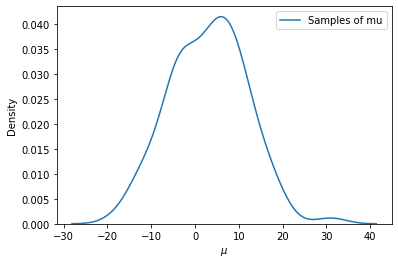

In [11]:
sns.kdeplot([model_joint.sample().mu.numpy() for _ in range(100)], label='Samples of mu')
plt.xlabel('$\mu$')
plt.legend()

An then genrating samples of $X$

tf.Tensor(11.457021, shape=(), dtype=float32)


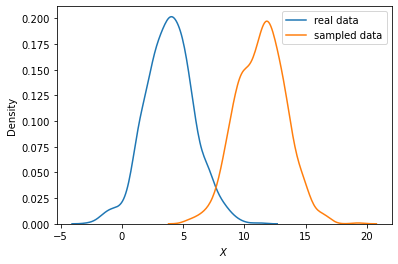

In [12]:
fig, ax = plt.subplots()

sample = model_joint.sample()
sample_mu = sample.mu
sample_X = sample.X
print(sample_mu)
sns.kdeplot(dataset, ax=ax, label='real data')
sns.kdeplot(sample_X, ax=ax, label='sampled data')
plt.xlabel('$X$')
plt.legend()

To get an expression for the ELBO (which will be the loss function) we need to model the log of the joint dist of mu and the fixed data $p(\mu, X= observed\ data) = p(X| \mu)p(\mu)$

In [13]:
model_joint_log_prob_fixed_data = lambda mu: model_joint.log_prob(mu=mu, X=dataset)

Lets try some mu's out and put it intp the joint log probabilty

Text(0, 0.5, '$log p(\\mu, X)$')

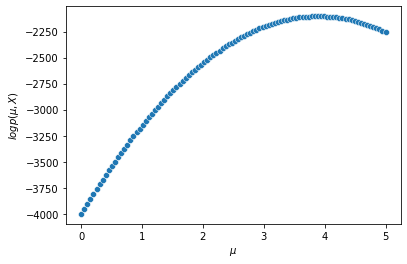

In [14]:
sns.scatterplot(x=np.linspace(0, 5, 100), y=[model_joint_log_prob_fixed_data(mu).numpy() for mu in np.linspace(0, 5, 100)])
plt.xlabel("$\mu$")
plt.ylabel("$log p(\mu, X)$")

To attempt to recreate the `.log_prob` function above we try to explicitly code the equation for it (at least what I think it is)

In [15]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def log_gauss(x, mu, sig):
    return -1/2* np.log(2.*np.pi) - np.log(sig)- np.power((x - mu)/sig, 2.)/2

custom_log_prob = lambda mu: np.log(gaussian(x=mu, mu=mu_0, sig=sigma_0)) + np.sum((np.log(gaussian(x=dataset, mu=mu, sig=sigma_fix))))

custom_log_prob_2 = lambda mu: log_gauss(x=mu, mu=mu_0, sig=sigma_0) + np.sum(log_gauss(x=dataset, mu=mu, sig=sigma_fix))

In [16]:
model_joint_log_prob_fixed_data(3.0).numpy()

-2203.9224

In [17]:
custom_log_prob(3.0)

-2203.9224072199486

In [18]:
custom_log_prob_2(3.0)

-2203.9224072199486

/Users/felix/Documents/learning/var_inference/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

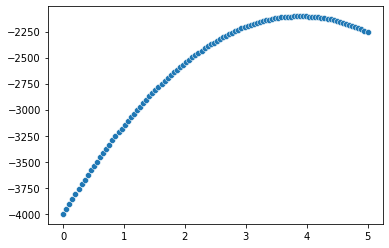

In [19]:
sns.scatterplot(np.linspace(0, 5, 100), [custom_log_prob(mu) for mu in np.linspace(0, 5, 100)])

Now we create a surrogate posterior, we propose that $\mu$ is normally distrubuted with learnable parameters $\mu_s$ and $\sigma_s$.

Our intial guess for  $\mu_s$ and $\sigma_s$ is our prior knowledge, namely $\mu_0$ and $\sigma_0$

In [20]:
mu_S = tf.Variable(mu_0, name="mu surrogate")

# bijector=tfp.bijectors.Softplus() - ensures the vairable is greater than 0
sigma_S = tfp.util.TransformedVariable(sigma_0, bijector=tfp.bijectors.Softplus(), name="sigma surrogate")

surrogate_posterior = tfp.distributions.Normal(loc=mu_S, scale=sigma_S, name="surrogate posterior")

We can look at the trainable parameters. Note that sigma surrogate is not equal to `sigma_0` this is because it is in its untransformed state, i.e the softplus operator has not been applied 

In [21]:
surrogate_posterior.trainable_variables

(<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=2.8>,
 <tf.Variable 'sigma surrogate:0' shape=() dtype=float32, numpy=9.999954>)

In [22]:
surrogate_posterior.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=13.887061>

Perform variational inference. Here we define the loss function, which is the negative elbo:
$$ELBO ≈ 1/L * \sum_{l=0}^{L-1} ( logp(\mu_l, X=D) - log q(\mu_l) )$$

Here we take $L$ samples from the surrogate posterior. This summation approximates the expectation, as in reality we cannot copmute the actual expectation over all possible $\mu$'s. (see video for derivation)

In [23]:
with tf.GradientTape() as g:
    samples = surrogate_posterior.sample(3)
    neg_elbo = - tf.reduce_mean(model_joint_log_prob_fixed_data(samples) - surrogate_posterior.log_prob(samples))

In [24]:
surrogate_posterior.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.9450171,  6.840042 , -6.339122 ], dtype=float32)>

In [25]:
model_joint_log_prob_fixed_data([2.0357795, 3.610072 , 3.1849785])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2536.2136, -2113.737 , -2166.748 ], dtype=float32)>

In [26]:
surrogate_posterior.log_prob([2.0357795, 3.610072 , 3.1849785])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.224444 , -3.2248049, -3.2222648], dtype=float32)>

We want to minimise this 

In [27]:
neg_elbo

<tf.Tensor: shape=(), dtype=float32, numpy=9603.263>

We can take partial derivative of negative elbo w.r.t the trainable parameters

In [28]:
g.gradient(neg_elbo, surrogate_posterior.trainable_variables)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1651.3069>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1319.4489>)

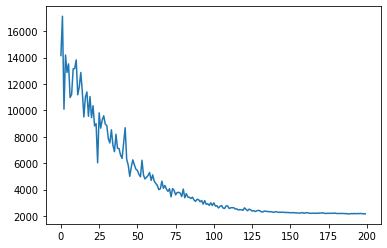

In [29]:
loss = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_joint_log_prob_fixed_data,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=200,
    sample_size=100
)
plt.plot(list(range(200)), loss)

Now we can inspect the parameters that have been learnt and compare to the true values (the true posterior)

In [30]:
mu_S

<tf.Variable 'mu surrogate:0' shape=() dtype=float32, numpy=3.8854706>

In [31]:
sigma_S

<TransformedVariable: dtype=float32, shape=[], fn="softplus", numpy=0.7164862>

In [32]:
mu_N

<tf.Tensor: shape=(), dtype=float32, numpy=3.8963208>

In [33]:
sigma_N

<tf.Tensor: shape=(), dtype=float32, numpy=0.06324428>

-------------

## All together 

Here we show all the neceaary code for building the model

In [34]:
# Generate data 
mu_true = 4.0
sigma_true = 2.0

X = tfp.distributions.Normal(loc=mu_true, scale=sigma_true)

N = 10000
dataset = X.sample(N)

# prior beliefs about mu
mu_0 = 1.0 # a guess, depends on appliacation
sigma_0 = 1.0 # how certian are we about our estimate of mu

sigma_fix = sigma_true # this is fixed a

# define generative model 
def generative_model(mu_0, sigma_0, sigma_fix, n_samples):
    mu = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Normal(loc=mu_0, scale=sigma_0, name="mu"))
    
    X = yield tfp.distributions.Normal(loc=mu * tf.ones(n_samples), scale=sigma_fix, name="X")

model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: generative_model(mu_0, sigma_0, sigma_fix, N)
)

# Define  the log probabilty of the model with fixed data i.e the actual dataset
model_joint_log_prob_fixed_data = lambda mu: model_joint.log_prob(mu=mu, X=dataset)

# Define the surrogate posterior, with 2 learnable parameters 
mu_S = tf.Variable(mu_0, name="mu surrogate")
# bijector=tfp.bijectors.Softplus() - ensures the vairable is greater than 0
sigma_S = tfp.util.TransformedVariable(sigma_0, bijector=tfp.bijectors.Softplus(), name="sigma surrogate")

surrogate_posterior = tfp.distributions.Normal(loc=mu_S, scale=sigma_S, name="surrogate posterior")

# perform gradient descent with Adam, sampling from the surrogate posterier 
# and computing gradients of the negative elbo w.r.t the learnable parameters 
# where neg_elbo = - tf.reduce_mean(model_joint_log_prob_fixed_data(samples) - surrogate_posterior.log_prob(samples))
# loss = tfp.vi.fit_surrogate_posterior(
#     target_log_prob_fn=model_joint_log_prob_fixed_data,
#     surrogate_posterior=surrogate_posterior,
#     optimizer=tf.optimizers.Adam(0.1),
#     num_steps=200,
#     sample_size=100
# )
# plt.plot(list(range(200)), loss)

One step at a time and at each step plot the kde of the actual data with a sample dataset generated using the parameters of the surrogate posterior, the distributions line up after several iterations

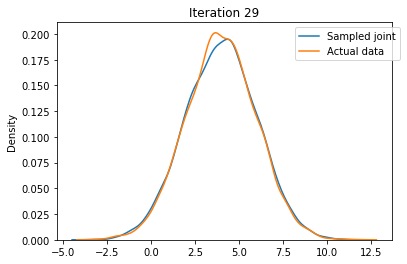

In [35]:
from IPython.display import clear_output
for i in range(30):
    tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model_joint_log_prob_fixed_data,
        surrogate_posterior=surrogate_posterior,
        optimizer=tf.optimizers.Adam(0.1),
        num_steps=1,
        sample_size=100
    )
    
    updated_model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(
        lambda: generative_model(mu_S, sigma_S, sigma_fix, N)
    )
    
    clear_output(wait=True)
    sns.kdeplot(updated_model_joint.sample().X, label='Sampled joint')
    sns.kdeplot(dataset, label='Actual data')
    plt.legend(bbox_to_anchor=(1.04, 1))
    plt.title(f'Iteration {i}')
    plt.show()

---------------------

### Example 2. Implement very simple DAG graphical model 

video [here](https://www.youtube.com/watch?v=yBc01ZeaFxw&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&ab_channel=MachineLearning%26Simulation)

- Happyness (0 or 1) depends on weather (0 or 1). Both are bernoulli distributed
- weather good with prob 0.3
- happyness good with prob 0.6 if weather bad
- happyness good with prob 0.9 if weather good

In [36]:
def happyness_model():
    weather = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Bernoulli(probs=0.3, name='weather')
    )
    
    # weather is 0 or 1 so this indexes the proba of happiness in thiss array 
    weather_to_happiness = tf.constant([0.6, 0.9])
    
    happyness = yield tfp.distributions.Bernoulli(
        probs=weather_to_happiness[weather], name="happyness"
    )
    
model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(happyness_model)

In [37]:
model_joint

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  weather=[],
  happyness=[]
) dtype=StructTuple(
  weather=int32,
  happyness=int32
)>

---------------

## Example 3, Maximum likelihood for simple graphical model
video [here](https://www.youtube.com/watch?v=l2f6Ic6SeqE&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=4&ab_channel=MachineLearning%26SimulationMachineLearning%26Simulation)

using the weather/happiness model as above but now using maximum likelihood to estimate the params of the bernoullis

In [38]:
def happiness_model(weather_prob, weather_to_happiness_probs):
    weather = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Bernoulli(probs=weather_prob, name='weather')
    )

    # weather is 0 or 1 so this indexes the proba of happiness in thiss array     
    happyness = yield tfp.distributions.Bernoulli(
        probs=weather_to_happiness_probs[weather], name="happyness"
    )

In [39]:
# we dont know these but need to create data with them
theta_weather = tf.constant(0.8)
thetas_happiness = tf.constant([0.7, 0.9])

define the joint model originally to genrate data 

In [40]:
model_joint_original = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: happiness_model(theta_weather, thetas_happiness)
)

Create data

In [41]:
dataset = model_joint_original.sample(100)

In [42]:
dataset

StructTuple(
  weather=<tf.Tensor: shape=(100,), dtype=int32, numpy=
    array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
           1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)>,
  happyness=<tf.Tensor: shape=(100,), dtype=int32, numpy=
    array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
           1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
           1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
           1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)>
)

Create learnable params

In [43]:
# must be between 0 and 1
theta_weather_fit = tfp.util.TransformedVariable(0.5, bijector=tfp.bijectors.SoftClip(0.0, 1.0), name="theta weather learnable")
thetas_happiness_fit = tfp.util.TransformedVariable([0.5, 0.5], bijector=tfp.bijectors.SoftClip(0.0, 1.0), name="thetas happiness learnable")

Model with mutable variables

In [44]:
model_joint_fit = tfp.distributions.JointDistributionCoroutineAutoBatched(
    lambda: happiness_model(theta_weather_fit, thetas_happiness_fit)
)

In [45]:
model_joint_fit.log_prob(dataset)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862944, -1.3862944, -1.3862944, -1.3862944, -1.3862944,
       -1.3862

Need to minimise the negative log likelihood 

In [46]:
neg_log_likelihood = lambda : -tf.reduce_sum(model_joint_fit.log_prob(dataset))

Text(0.5, 0, 'iteration')

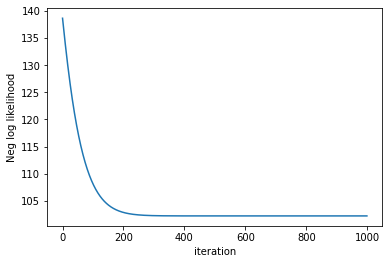

In [47]:
loss = tfp.math.minimize(
    loss_fn=neg_log_likelihood,
    optimizer=tf.optimizers.Adam(0.01),
    num_steps=1000
)

plt.plot(range(1000), loss)
plt.ylabel("Neg log likelihood")
plt.xlabel("iteration")

View estimated values after training

In [48]:
theta_weather_fit

<TransformedVariable: dtype=float32, shape=[], fn="soft_clip", numpy=0.7899996>

In [49]:
thetas_happiness_fit

<TransformedVariable: dtype=float32, shape=[2], fn="soft_clip", numpy=array([0.6190476, 0.8227843], dtype=float32)>

Compare to real values 

In [50]:
thetas_happiness

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7, 0.9], dtype=float32)>

In [51]:
theta_weather

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

Comparing to the actual values we see there is a difference. 

This is due to the lack of data we have, not due to optimisation. 

If we use the original model to evaluate the log prob on the dataset and comapare to the log prob on fitted model, we the fitted model is more likely for the data set.

In [52]:
tf.reduce_sum(model_joint_original.log_prob(dataset))

<tf.Tensor: shape=(), dtype=float32, numpy=-104.77972>

In [53]:
tf.reduce_sum(model_joint_fit.log_prob(dataset))

<tf.Tensor: shape=(), dtype=float32, numpy=-102.25517>

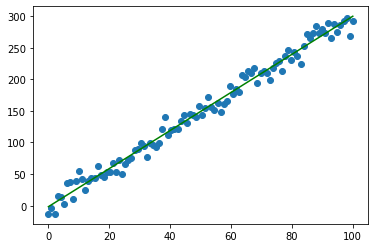

In [54]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
X = np.linspace(0,100, 100)
y = X * 3 + np.random.normal(scale=10, size=100)
plt.scatter(X, y)

model = LinearRegression().fit(X.reshape(-1,1),y)
plt.plot(X, model.predict(X.reshape(-1, 1)), color='g')

## References 
All example come from this great [youtube channel](https://www.youtube.com/channel/UCh0P7KwJhuQ4vrzc3IRuw4Q)
- [example 1]( [tutorial](https://www.youtube.com/watch?v=dxwVMeK988Y&ab_channel=MachineLearning%26SimulationMachineLearning%26Simulation)
- [example 2](https://www.youtube.com/watch?v=yBc01ZeaFxw&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&ab_channel=MachineLearning%26Simulation)
- [example 3](https://www.youtube.com/watch?v=l2f6Ic6SeqE&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=4&ab_channel=MachineLearning%26SimulationMachineLearning%26Simulation)